# Single-pass wavefront propagation (exponential n2 decay)

Take the n2 values from the RHS plot in Boaz's presentation, where there is a max value of approximately 30, which then drops exponentially. Use enough crystal slices to be reasonably sure it's converged.

***
#### Imports

In [ ]:
import array
import math
import numpy as np
from pykern import pkcli
from pykern.pkcollections import PKDict
import os

# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser

from rslaser.pulse import pulse
from rslaser.optics import element
from rslaser.optics import drift
from rslaser.optics import crystal
from rslaser.utils import srwl_uti_data as srwutil
from rsmath import lct as rslct

import scipy.constants as const
from scipy.ndimage import gaussian_filter

import srwlib
from srwlib import srwl

# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

#### File Data

In [ ]:
package_data_dir = rslaser.pkg_resources.resource_filename ('rslaser', 'package_data')

files = PKDict(
    meta = os.path.join(package_data_dir, 'wfs_meta.dat'),
    ccd = os.path.join(package_data_dir, 'ccd_pump_off.txt'), #_off_peak_timing.txt'), #_pump_off.txt'),
    wfs = os.path.join(package_data_dir, 'wfs_pump_off.txt'), #_off_peak_timing.txt'), #_pump_off.txt')
)

***
### Pulse Initialization

In [ ]:
params = PKDict(
    photon_e_ev = 1.5498, # Photon energy [eV], calculated from 800nm wavelength
    nslice      = 5,
    pulseE      = 1.0e-6,
    tau_fwhm    = 300.0e-12 / math.sqrt(2.),
    sigx_waist  = 1.2e-3 /1.18,
    sigy_waist  = 1.2e-3 /1.18,
)

thisPulse = pulse.LaserPulse(params, files)

In [ ]:
# Plot initial wavefront
wfr_exp_init = thisPulse.slice[0].wfr

x_exp_init=np.linspace(wfr_exp_init.mesh.xStart,wfr_exp_init.mesh.xFin,wfr_exp_init.mesh.nx)
y_exp_init=np.linspace(wfr_exp_init.mesh.yStart,wfr_exp_init.mesh.yFin,wfr_exp_init.mesh.ny)

e_total = thisPulse.extract_total_2d_elec_fields()
intensity_2D_exp_init = 0.5 *const.c *const.epsilon_0 *(e_total.re**2.0 + e_total.im**2.0)

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_init*(1e3), x_exp_init*(1e3), intensity_2D_exp_init, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Intensity (pump_off)')

In [ ]:
# initial phase
phase_exp_init = srwlib.array('d', [0]*wfr_exp_init.mesh.nx*wfr_exp_init.mesh.ny) # "flat" array to take 2D data
srwl.CalcIntFromElecField(phase_exp_init, wfr_exp_init, 0, 4, 3, wfr_exp_init.mesh.eStart, 0, 0) #extracts the phase; must use double precision

# Reshaping data from flat to 2D array
phase_2d_exp_init = np.array(phase_exp_init).reshape((wfr_exp_init.mesh.nx, wfr_exp_init.mesh.ny), order='C').astype(np.float64)

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_init*(1e3), x_exp_init*(1e3), phase_2d_exp_init, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_title('Phase (pump off)')

***
### Crystal Initialization

In [ ]:
z       = np.array([ 0.0,  0.5,  1.0, 1.5, 2.0, 2.5])
n2_plot = np.array([29.0, 19.0, 11.5, 6.7, 4.0, 2.5])

from scipy import interpolate
plot_fit = interpolate.splrep(z, n2_plot)

# new_z = z
# new_n2 = interpolate.splev(new_z, plot_fit)

# full_z = np.linspace(0.0,2.5,100)
# full_n2 = interpolate.splev(full_z, plot_fit)

# plt.figure()
# plt.plot(z, n2_plot, '.r', label='Input')
# plt.plot(full_z, full_n2, 'k', label='Fit')
# plt.xlabel('longitudinal position z/ cm')
# plt.ylabel('n$_2$/m$^{-2}$')
# plt.legend()
# plt.show()

In [ ]:
num_slices = 5
n0 = 1.76
n2 = 16.0 #5.0
L_cryst = 0.025
# gamma = np.sqrt(n2/n0)

new_z = (L_cryst /num_slices) *(np.arange(num_slices)+0.5)

crystal_params = PKDict(
    length      = L_cryst, # [m]
    nslice      = num_slices,
    # l_scale     = 0.001, #abcd_lct value #0.004, 
    n0          = [n0 for _ in range(num_slices)],
    n2          = interpolate.splev(new_z, plot_fit).tolist(), #[n2 for _ in range(num_slices)],
    pump_energy = 0.035,  # [J]
    pump_waist  = 1.2e-3 /1.18,  # [m]
    # A           = np.cos(gamma*L_cryst),
    # B           = (1/gamma)*np.sin(gamma*L_cryst),
    # C           = -gamma*np.sin(gamma*L_cryst),
    # D           = np.cos(gamma*L_cryst)
)

e_crystal = crystal.Crystal(crystal_params)

***
## Propagate through Crystal Once

In [ ]:
prop_type = 'n0n2_srw'
gain = 1

LP = pulse.LaserPulse(params, files)
nslices_pulse = len(LP.slice)
e_crystal = crystal.Crystal(crystal_params)
nslices_crystal = len(e_crystal.slice)

n_photons_before = 0
for laser_index_i in np.arange(LP.nslice):
        n_photons_before += np.sum(LP.slice[laser_index_i].n_photons_2d.mesh)

print('\nPropagating ', nslices_pulse, 'laser slices through ', nslices_crystal,' crystal slices')
LP = e_crystal.propagate(LP, prop_type, gain)

# instantiate a drift
L_drift = 0.50  # [m]
e_drift = drift.Drift(L_drift)
LP = e_drift.propagate(LP, 'default')

wfr_sim_final=LP.slice[0].wfr
x_sim_final=np.linspace(wfr_sim_final.mesh.xStart,wfr_sim_final.mesh.xFin,wfr_sim_final.mesh.nx)
y_sim_final=np.linspace(wfr_sim_final.mesh.yStart,wfr_sim_final.mesh.yFin,wfr_sim_final.mesh.ny)

***
## Simulation Plots

In [ ]:
e_total = LP.extract_total_2d_elec_fields()
intens_2d_sim_final = 0.5 *const.c *const.epsilon_0 *(e_total.re**2.0 + e_total.im**2.0)
    
with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_sim_final*(1e3), x_sim_final*(1e3), intens_2d_sim_final, cmap=plt.cm.viridis, shading='auto') #viridis
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Intensity (simulation)')

In [ ]:
# transmitted pulse - phase
phase_sim_final = srwlib.array('d', [0]*wfr_sim_final.mesh.nx*wfr_sim_final.mesh.ny) # "flat" array to take 2D phase data
srwl.CalcIntFromElecField(phase_sim_final, wfr_sim_final, 0, 4, 3, wfr_sim_final.mesh.eStart, 0, 0) #extracts the phase; must use double precision

# Reshaping data from flat to 2D array
phase_2d_sim_final = np.array(phase_sim_final).reshape((wfr_sim_final.mesh.nx, wfr_sim_final.mesh.ny), order='C').astype(np.float64)

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_sim_final*(1e3), x_sim_final*(1e3), phase_2d_sim_final, cmap=plt.cm.viridis, shading='auto') #np.unwrap(phase_2d_sim_final)
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')#[mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')#[mm]')
    ax.set_title('Phase (simulation)')

In [ ]:
# Plot difference in intensities

diff_intensity_2D_sim = intens_2d_sim_final - intensity_2D_exp_init

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_sim_final*(1e3), x_sim_final*(1e3), diff_intensity_2D_sim, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Intensity (sim difference)')

print(np.max(intens_2d_sim_final)-np.max(intensity_2D_exp_init))

prop_n_photons = 0
for laser_index_i in np.arange(LP.nslice):
        prop_n_photons += np.sum(LP.slice[laser_index_i].n_photons_2d.mesh)
print(prop_n_photons -n_photons_before)

***
## Peak Timing and Off-Peak Timing Plots

In [ ]:
files = PKDict(
    meta = os.path.join(package_data_dir, 'wfs_meta.dat'),
    ccd = os.path.join(package_data_dir, 'ccd_off_peak_timing.txt'), #_pump_off.txt'),
    wfs = os.path.join(package_data_dir, 'wfs_off_peak_timing.txt'), #_pump_off.txt')
)

offpeakPulse = pulse.LaserPulse(params, files)
wfr_exp_final_op = offpeakPulse.slice[0].wfr

# _op = _off_peak

x_exp_final_op=np.linspace(wfr_exp_final_op.mesh.xStart,wfr_exp_final_op.mesh.xFin,wfr_exp_final_op.mesh.nx)
y_exp_final_op=np.linspace(wfr_exp_final_op.mesh.yStart,wfr_exp_final_op.mesh.yFin,wfr_exp_final_op.mesh.ny)

In [ ]:
e_total = offpeakPulse.extract_total_2d_elec_fields()
intensity_2D_exp_final_op = 0.5 *const.c *const.epsilon_0 *(e_total.re**2.0 + e_total.im**2.0)

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_final_op*(1e3), x_exp_final_op*(1e3), intensity_2D_exp_final_op, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Intensity (off-peak timing)')

In [ ]:
files = PKDict(
    meta = os.path.join(package_data_dir, 'wfs_meta.dat'),
    ccd = os.path.join(package_data_dir, 'ccd_peak_timing.txt'), #_off_peak_timing.txt'), #_pump_off.txt'),
    wfs = os.path.join(package_data_dir, 'wfs_peak_timing.txt'), #_off_peak_timing.txt'), #_pump_off.txt')
)

peakPulse = pulse.LaserPulse(params, files)
wfr_exp_final = peakPulse.slice[0].wfr

x_exp_final=np.linspace(wfr_exp_final.mesh.xStart,wfr_exp_final.mesh.xFin,wfr_exp_final.mesh.nx)
y_exp_final=np.linspace(wfr_exp_final.mesh.yStart,wfr_exp_final.mesh.yFin,wfr_exp_final.mesh.ny)

In [ ]:
e_total = peakPulse.extract_total_2d_elec_fields()
intensity_2D_exp_final = 0.5 *const.c *const.epsilon_0 *(e_total.re**2.0 + e_total.im**2.0)

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_final*(1e3), x_exp_final*(1e3), intensity_2D_exp_final, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Intensity (peak timing)')

In [ ]:
# Extract phase from experimental post-prop wavefront
phase_exp_final = srwlib.array('d', [0]*wfr_exp_final.mesh.nx*wfr_exp_final.mesh.ny) # "flat" array to take 2D data
srwl.CalcIntFromElecField(phase_exp_final, wfr_exp_final, 0, 4, 3, wfr_exp_final.mesh.eStart, 0, 0) #extracts the phase; must use double precision

# Reshaping phase data from flat to 2D array
phase_2d_exp_final = np.array(phase_exp_final).reshape((wfr_exp_final.mesh.nx, wfr_exp_final.mesh.ny), order='C').astype(np.float64)

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_final*(1e3), x_exp_final*(1e3), phase_2d_exp_final, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_title('Phase (peak timing)')

In [ ]:
# Plot difference in intensities

diff_intensity_2D_exp_final = intensity_2D_exp_final - intensity_2D_exp_final_op

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_final*(1e3), x_exp_final*(1e3), diff_intensity_2D_exp_final, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Intensity (data difference)')
    
print(np.max(intensity_2D_exp_final) - np.max(intensity_2D_exp_final_op))

peak_n_photons = 0
for laser_index_i in np.arange(peakPulse.nslice):
        peak_n_photons += np.sum(peakPulse.slice[laser_index_i].n_photons_2d.mesh)

offpeak_n_photons = 0
for laser_index_i in np.arange(offpeakPulse.nslice):
        offpeak_n_photons += np.sum(offpeakPulse.slice[laser_index_i].n_photons_2d.mesh)

print(peak_n_photons -offpeak_n_photons)

***
# Single pass, number of photons in laser as a function of number of crystal slices


Propagating  50 laser slices through  6  crystal slices

Propagating  50 laser slices through  7  crystal slices

Propagating  50 laser slices through  8  crystal slices

Propagating  50 laser slices through  9  crystal slices

Propagating  50 laser slices through  10  crystal slices


Text(0.5, 0, 'Number of Crystal Slices')

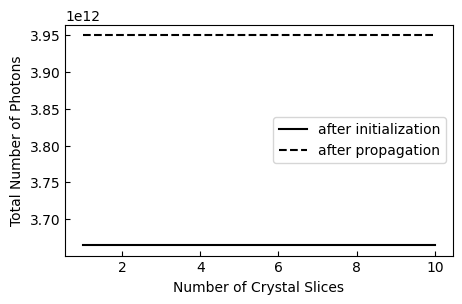

In [18]:
params = PKDict(
        photon_e_ev=1.5498, # Photon energy [eV], calculated from 800nm wavelength
        nslice = 50,
        pulseE      = 1.0e-6,
        tau_fwhm    = 300.0e-12 / math.sqrt(2.),
        sigx_waist  = 1.2e-3 /1.18,
        sigy_waist  = 1.2e-3 /1.18,
)
prop_type = 'n0n2_srw'

max_num_c_slices = 10

total_n_photons_i = np.zeros(max_num_c_slices)
total_n_photons   = np.zeros(max_num_c_slices)

L_cryst = 2.5/100.0

for num_c_slices in np.arange(max_num_c_slices):
    
    num_slices = num_c_slices+1
    new_z = (L_cryst /num_slices) *(np.arange(num_slices)+0.5)
    crystal_params = PKDict(
        length = L_cryst,  # [m]
        nslice = num_c_slices+1,
        n0          = [1.76 for _ in range(num_slices)],
        n2          = interpolate.splev(new_z, plot_fit).tolist(), #[n2 for _ in range(num_slices)],
        pump_energy = 0.035,  # [J]
        pump_waist  = 1.2e-3 /1.18,  # [m]
    )
    e_crystal = crystal.Crystal(crystal_params)
    thisPulse = pulse.LaserPulse(params,files)
    nslices_pulse = len(thisPulse.slice)
    
    for laser_index_i in np.arange(nslices_pulse):
        total_n_photons_i[num_c_slices] += np.sum(np.sum(thisPulse.slice[laser_index_i].n_photons_2d.mesh))
    
    if (num_c_slices < max_num_c_slices):
        print('\nPropagating ', nslices_pulse, 'laser slices through ', num_c_slices+1,' crystal slices')
        thisPulse = e_crystal.propagate(thisPulse, prop_type,1)

    for laser_index_p in np.arange(nslices_pulse):
        total_n_photons[num_c_slices] += np.sum(np.sum(thisPulse.slice[laser_index_p].n_photons_2d.mesh))

n_c_slice = np.arange(1,max_num_c_slices + 1)

fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.plot(n_c_slice,total_n_photons_i,'k',label='after initialization')
plt.plot(n_c_slice,total_n_photons,'--k',label='after propagation')
plt.legend()
ax.tick_params(direction="in")
ax.set_ylabel(r'Total Number of Photons')
ax.set_xlabel(r'Number of Crystal Slices')


Text(0.5, 0, 'Number of Crystal Slices')

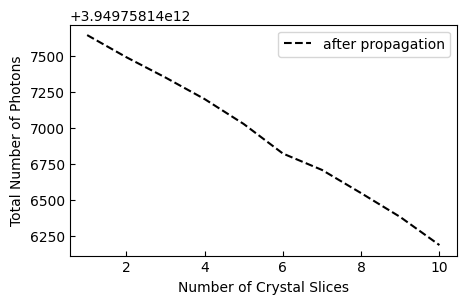

In [19]:
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
#plt.plot(n_c_slice,total_n_photons_i,'k',label='after initialization')
plt.plot(n_c_slice,total_n_photons,'--k',label='after propagation')
plt.legend()
ax.tick_params(direction="in")
ax.set_ylabel(r'Total Number of Photons')
ax.set_xlabel(r'Number of Crystal Slices')

***
# Peak intensity as a function of number of crystal slices

In [ ]:
params = PKDict(
        photon_e_ev=1.5498, # Photon energy [eV], calculated from 800nm wavelength
        nslice = 50,
        pulseE      = 1.0e-6,
        tau_fwhm    = 300.0e-12 / math.sqrt(2.),
        sigx_waist  = 1.2e-3 /1.18,
        sigy_waist  = 1.2e-3 /1.18,
)
prop_type = 'n0n2_srw'

max_num_c_slices = 10

peak_intensity = np.zeros(max_num_c_slices)

L_cryst = 2.5/100.0

for num_c_slices in np.arange(max_num_c_slices):
    
    num_slices = num_c_slices+1
    new_z = (L_cryst /num_slices) *(np.arange(num_slices)+0.5)
    crystal_params = PKDict(
        length = L_cryst,  # [m]
        nslice = num_c_slices+1,
        n0          = [1.76 for _ in range(num_slices)],
        n2          = interpolate.splev(new_z, plot_fit).tolist(), #[n2 for _ in range(num_slices)],
        pump_energy = 0.035,  # [J]
        pump_waist  = 1.2e-3 /1.18,  # [m]
    )
    e_crystal = crystal.Crystal(crystal_params)
    thisPulse = pulse.LaserPulse(params,files)
    nslices_pulse = len(thisPulse.slice)
        
    if (num_c_slices < max_num_c_slices):
        print('\nPropagating ', nslices_pulse, 'laser slices through ', num_c_slices+1,' crystal slices')
        thisPulse = e_crystal.propagate(thisPulse, prop_type,1)

    e_total = thisPulse.extract_total_2d_elec_fields()
    intensity_2D_exp_init = 0.5 *const.c *const.epsilon_0 *(e_total.re**2.0 + e_total.im**2.0)
    peak_intensity[num_c_slices] = np.max(intensity_2D_exp_init)

n_c_slice = np.arange(1,max_num_c_slices + 1)

fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.plot(n_c_slice,peak_intensity,'k',label='after propagation')
plt.legend()
ax.tick_params(direction="in")
ax.set_ylabel(r'Peak Intensity')
ax.set_xlabel(r'Number of Crystal Slices')



Propagating  50 laser slices through  1  crystal slices

Propagating  50 laser slices through  2  crystal slices

Propagating  50 laser slices through  3  crystal slices

Propagating  50 laser slices through  4  crystal slices

Propagating  50 laser slices through  5  crystal slices

Propagating  50 laser slices through  6  crystal slices
